<a href="https://colab.research.google.com/github/Neena-A/Wat-Pneu/blob/main/C_InceptionNetV3100epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"neenamaryalex","key":"e428483a572b398502b259d40a37f628"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [02:00<00:00, 20.4MB/s]
100% 2.29G/2.29G [02:00<00:00, 20.5MB/s]


In [ ]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
from keras.models import Sequential,load_model
from keras.layers import Conv2D,Activation, MaxPooling2D,Dense,Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model


#import numpy as np
#from tensorflow.keras.preprocessing import image
#import os

#import cv2

In [ ]:
def Build_CNN_Model():
    
    # -------------------------------------------------------------------------
    # -------------------------------------------------------------------------
    # load Inception model
    Inception = InceptionV3(include_top=True, input_shape=(299, 299, 3))

    # mark loaded layers as trainable
    for layer in Inception.layers:
	    layer.trainable = True      
	
  
    #  Softmax Classifier
    Class_layer = Dense(2)(Inception.layers[-2].output)
    
    Softmax_layer = Activation('softmax')(Class_layer)
    
    
	# define new model    
    model = Model(inputs=Inception.inputs, outputs=Softmax_layer)
    
        
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 

In [ ]:
# train and evalluate cnn model
def Train_CNN_Model(model):
    
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     )
    
    valid_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
   
   
    # prepare iterators
    batch_size=32
    train_it = train_datagen.flow_from_directory('/content/chest_xray/train',batch_size=batch_size, target_size=(299, 299))
    valid_it = valid_datagen.flow_from_directory('/content/chest_xray/val',batch_size=batch_size, target_size=(299, 299))


    epochs=100;
    
    history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=valid_it, validation_steps=len(valid_it), epochs=epochs, verbose=1)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model.h5')

In [ ]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('/content/chest_xray/test', 
                                               shuffle=False,batch_size=batch_size, target_size=(299, 299))
    
    y_true = test_it.classes;

    y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()
    

In [ ]:
model = Build_CNN_Model()

96112376/96112376 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
163/163 [==============================] - 231s 1s/step - loss: 0.1766 - accuracy: 0.9344 - val_loss: 19.7941 - val_accuracy: 0.6875
Epoch 2/100
163/163 [==============================] - 185s 1s/step - loss: 0.1284 - accuracy: 0.9511 - val_loss: 0.9808 - val_accuracy: 0.8750
Epoch 3/100
163/163 [==============================] - 184s 1s/step - loss: 0.1164 - accuracy: 0.9601 - val_loss: 0.2206 - val_accuracy: 0.8125
Epoch 4/100
163/163 [==============================] - 186s 1s/step - loss: 0.0941 - accuracy: 0.9651 - val_loss: 0.2278 - val_accuracy: 0.8750
Epoch 5/100
163/163 [==============================] - 184s 1s/step - loss: 0.0705 - accuracy: 0.9739 - val_loss: 0.1962 - val_accuracy: 0.8750
Epoch 6/100
163/163 [==============================] - 182s 1s/step - loss: 0.0800 - accuracy: 0.9697 - val_loss: 0.3906 - val_accuracy: 0.8125
Epoch 7/100
163/163 [==============================] - 183s 1s/step - loss: 0.0655 - accuracy: 0.9743 - val_loss: 0.5643 - val_accuracy

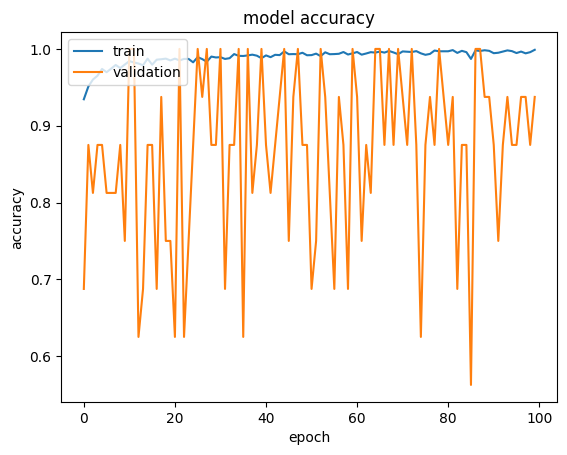

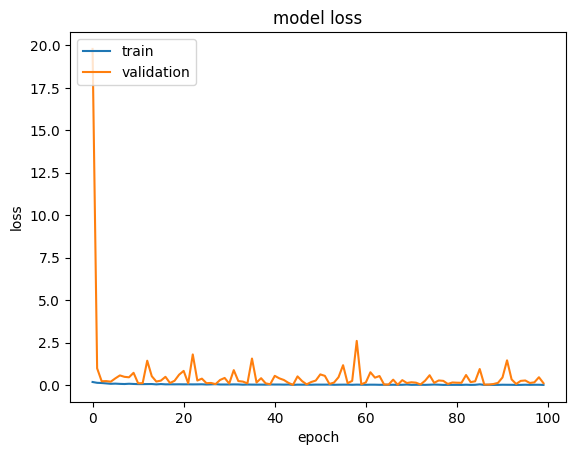

In [ ]:


Train_CNN_Model(model)



    


Found 624 images belonging to 2 classes.


<ipython-input-8-a2521cd37a1c>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)


20/20 [==============================] - 8s 303ms/step

Confusion Matrix
 -------------------------
[[214  20]
 [ 15 375]]
Accuracy: 0.943910
Precision: 0.949367
Recall: 0.961538
F1 score: 0.955414
ROC AUC: 0.986993


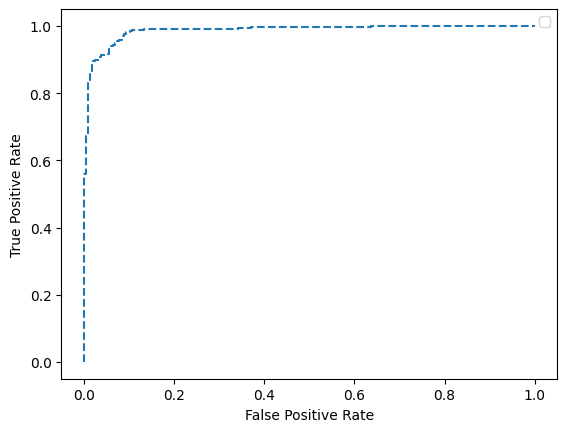

In [ ]:
Evaluate_CNN_Model()